#Titanic - Kaggle Training

In [1]:
import numpy as np
import pandas as pd
import csv as csv
import sys
#set PYTHONPATH
sys.path.append('C:/Users/User/Desktop/datasciences_tools/')

import os
from time import time
import operator

from Tools.tools import *

from sklearn.tree import *
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
import sklearn.svm as svm
from sklearn.preprocessing import *
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV    

import matplotlib.pyplot as plt
%matplotlib inline 
%qtconsole

In [2]:
# Multiprocessing
os.system('taskset -p 0xffffffff %d' % os.getpid())

1

##Preprocessing

In [4]:
train = pd.read_csv("M:/datasciences/Projets/Kaggle/Titanic/train.csv")
test = pd.read_csv("M:/datasciences/Projets/Kaggle/Titanic/test.csv")
#train = pd.read_csv("C:/Users/User/Desktop/datasciences_tools/data/train.csv")
#test = pd.read_csv("C:/Users/User/Desktop/datasciences_tools/data/test.csv")

## NA imputation
feature_columns_to_use = ['Pclass', 'Sex', 'Age', 'Fare', 'Parch', 'Embarked', 'SibSp']
big_X = train[feature_columns_to_use].append(test[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)

# Let's rebuild train & test datasets with imputed values
train_X = big_X_imputed[:train.shape[0]]
test_X = big_X_imputed[train.shape[0]:]

# Male = 1 / Female = 0  using map function
train_X['Gender'] = train_X['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test_X['Gender'] = test_X['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
train_X = train_X.drop(['Sex'], axis=1)
test_X = test_X.drop(['Sex'], axis=1)

## Dummies
##Embarked split
train_X = feature_to_dummy(train_X, 'Embarked')
test_X = feature_to_dummy(test_X, 'Embarked')

#Pclass
train_X = feature_to_dummy(train_X, 'Pclass')
test_X = feature_to_dummy(test_X, 'Pclass')

train_Y = train['Survived']

## Categorical variable => Ordinal encoding
# TODO : check here http://fr.slideshare.net/DataRobot/gradient-boosted-regression-trees-in-scikitlearn?next_slideshow=1

C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


##Data-visualisation
TODO

## Features selection

In [5]:
#with linear SVC **Gridsearched**
lin_svc = LinearSVC(C=100)
lin_svc.fit_transform(train_X, train_Y)

#with rf **Gridsearched**
rf = RandomForestClassifier(n_estimators=100, max_features=1, criterion='entropy') 
rf.fit_transform(train_X, train_Y)

#with logitCV **NOT DONE YET!**
logitcv = lm.LogisticRegressionCV()
logitcv.fit_transform(train_X, train_Y)

array([[ 1.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  1.],
       [ 1.,  1.,  0.],
       [ 1.,  0.,  1.]])

##Models

###Random Forests

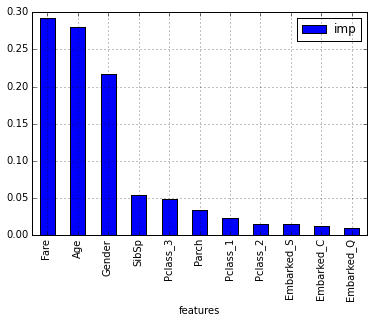

In [75]:
model_rf = RandomForestClassifier(n_estimators = 10,
                                  max_depth = None,
                                  bootstrap = True,
                                  criterion = "entropy")

#features importance
imp_list = list(zip(train_X.columns, np.transpose(forest.feature_importances_)))
imp_list.sort(key=operator.itemgetter(1), reverse=True)
imp_rf = pd.DataFrame(imp_list, columns=['features', 'imp'])
imp_rf.plot(kind='bar', x='features')

Let's keep the 3 first features.
####The next line can be change if we decide to keep more variable :

In [76]:
train_X_imp = rf.fit_transform(train_X, train_Y)

In [ ]:
#combining the feature with pipeline.FeatureUnion => use it in the grid
combined_features = FeatureUnion([("rf_select", rf), ("rf_est", model_rf)])
# Use combined features to transform dataset: 
X_features = combined_features.fit(train_X, train_Y).transform(train_X)
#TODO : modifier la FeatureUnion qui ne sert à rien ici.


###SVC

In [53]:
##SVC-lin
model_svc = svm.SVC(kernel='linear')
res_svc = model_svc.fit(train_X, train_Y) 

###Logistic

In [ ]:
## Logistic
model_logit = lm.LogisticRegression()
res_logit = model_logit.fit(train_X, train_Y)
#coef
pd.DataFrame(list(zip(train_X.columns, np.transpose(res_logit.coef_))))

##Find the best parameters (Gridsearch)

###Grid - parameters

In [39]:
param_grid_rf = {"n_estimators" : [10, 20, 30, 50, 100, 110, 150, 180, 190],
              "max_depth": [3, None],
              "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
              
param_grid_svc = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

param_grid_GBR = {
              'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17, 100],
              'max_features': [1.0, 0.3, 0.1], #percentage
              }

param_grid_ada = {
            'n_estimators': [15, 20, 25, 30, 35, 40, 45, 100],
            'learning_rate': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'random_state' : [10,20,30,40,50,70,80,90]
            }

param_ExtraTrees = {
            'n_estimators': [100,200,300,400,500,600,700,1000],
            'max_depth': [1, 2, 5, 7, 10],
            'min_samples_leaf': [1, 2 , 5, 7, 10],
            'min_samples_split': [1, 2 , 5, 7, 10]
            }

param_grid_logit = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                   'random_state' : [10,20,30,40,50,70,80,90]
                   }

    

### Hyperparametrisation (gridsearch)

In [16]:
model_rf = RandomForestClassifier()
grid_search = GridSearchCV(model_rf, param_grid=param_grid_rf, n_jobs=12)
start = time()
grid_search.fit(train_X, train_Y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report_grid(grid_search.grid_scores_)

GridSearchCV took 285.91 seconds for 6480 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.840 (std: 0.028)
Parameters: {'max_features': 0.6, 'min_samples_split': 3, 'criterion': 'entropy', 'n_estimators': 110, 'max_depth': None, 'bootstrap': True, 'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: 0.837 (std: 0.020)
Parameters: {'max_features': 0.5, 'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 50, 'max_depth': None, 'bootstrap': True, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.837 (std: 0.023)
Parameters: {'max_features': 0.8, 'min_samples_split': 1, 'criterion': 'entropy', 'n_estimators': 180, 'max_depth': None, 'bootstrap': True, 'min_samples_leaf': 3}



In [80]:
grid_search = GridSearchCV(model_svc, param_grid=param_grid_svc, n_jobs=12)
start = time()
grid_search.fit(train_X, train_Y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report_grid(grid_search.grid_scores_)

GridSearchCV took 270.82 seconds for 12 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.789 (std: 0.020)
Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 2
Mean validation score: 0.788 (std: 0.010)
Parameters: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.787 (std: 0.011)
Parameters: {'C': 1, 'kernel': 'linear'}



This is how you tune GradientBoostingClassifier :

1. Set n_estimators very high (eg 3000)
2. grid search learning_rate, max_depth, min_sample_leaf & max_features

In [7]:
GBR = GradientBoostingClassifier(n_estimators=3000)
start_time = time()
grid_search = GridSearchCV(GBR, param_grid_GBR, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)

It took 112.37442779541016 seconds
Model with rank: 1
Mean validation score: 0.826 (std: 0.016)
Parameters: {'max_features': 0.3, 'min_samples_leaf': 100, 'learning_rate': 0.05, 'max_depth': 4}

Model with rank: 2
Mean validation score: 0.824 (std: 0.019)
Parameters: {'max_features': 0.3, 'min_samples_leaf': 100, 'learning_rate': 0.1, 'max_depth': 6}

Model with rank: 3
Mean validation score: 0.824 (std: 0.030)
Parameters: {'max_features': 0.1, 'min_samples_leaf': 3, 'learning_rate': 0.01, 'max_depth': 4}



Now that we have the best hyperparameters settings :

3. let's set n_estimators even higher (eg 9000)
4. tune learning_rate as precisely as possible.

In [14]:
GBR = GradientBoostingClassifier(n_estimators=9000, max_features=0.3, min_samples_leaf=100, max_depth=4)
param_GBR = { 'learning_rate': [0.01,0.012,0.013,0.014,0.015,0.016,0.017,0.18,0.019,0.02,0.021,0.025,0.026,0.027,0.028]}
start_time = time()
grid_search = GridSearchCV(GBR, param_GBR, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)

It took 34.77398896217346 seconds
Model with rank: 1
Mean validation score: 0.828 (std: 0.019)
Parameters: {'learning_rate': 0.021}

Model with rank: 2
Mean validation score: 0.827 (std: 0.018)
Parameters: {'learning_rate': 0.019}

Model with rank: 3
Mean validation score: 0.826 (std: 0.016)
Parameters: {'learning_rate': 0.014}



In [19]:
best_rf = RandomForestClassifier(n_estimators = 110,
                                  max_depth = None,
                                  min_samples_leaf = 3,
                                  max_features = 0.6,
                                  min_samples_split = 10,
                                  bootstrap = True,
                                  criterion = "entropy")

ada_rf = AdaBoostClassifier(best_rf, n_estimators=4, random_state=93)

start_time = time()
grid_search = GridSearchCV(ada_rf, param_grid_ada, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)

It took 1179.2584490776062 seconds
Model with rank: 1
Mean validation score: 0.818 (std: 0.012)
Parameters: {'random_state': 70, 'n_estimators': 15, 'learning_rate': 0.3}

Model with rank: 2
Mean validation score: 0.818 (std: 0.019)
Parameters: {'random_state': 90, 'n_estimators': 15, 'learning_rate': 0.3}

Model with rank: 3
Mean validation score: 0.817 (std: 0.021)
Parameters: {'random_state': 10, 'n_estimators': 15, 'learning_rate': 0.3}



In [22]:
param_ada = { 'learning_rate': [0.026,0.027,0.028, 0.029, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]}
best_rf = RandomForestClassifier(n_estimators = 110,
                                  max_depth = None,
                                  min_samples_leaf = 3,
                                  max_features = 0.6,
                                  min_samples_split = 10,
                                  bootstrap = True,
                                  criterion = "entropy")

ada_rf = AdaBoostClassifier(best_rf, n_estimators=15, random_state=70)

start_time = time()
grid_search = GridSearchCV(ada_rf, param_ada, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)


It took 24.545403957366943 seconds
Model with rank: 1
Mean validation score: 0.836 (std: 0.028)
Parameters: {'learning_rate': 0.027}

Model with rank: 2
Mean validation score: 0.835 (std: 0.026)
Parameters: {'learning_rate': 0.026}

Model with rank: 3
Mean validation score: 0.835 (std: 0.026)
Parameters: {'learning_rate': 0.028}



In [40]:
model_logit = lm.LogisticRegression(penalty='l2')
start_time = time()
grid_search = GridSearchCV(model_logit, param_grid_logit, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)

It took 12.106693029403687 seconds
Model with rank: 1
Mean validation score: 0.792 (std: 0.008)
Parameters: {'C': 100, 'random_state': 10}

Model with rank: 2
Mean validation score: 0.792 (std: 0.008)
Parameters: {'C': 100, 'random_state': 20}

Model with rank: 3
Mean validation score: 0.792 (std: 0.008)
Parameters: {'C': 100, 'random_state': 30}



In [43]:
#TODO !
model_logitCV = lm.LogisticRegressionCV()
model_logitCV.score

<bound method LogisticRegressionCV.score of LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)>

##Best models

In [47]:
best_adaboost = AdaBoostClassifier(
        n_estimators = 20,
        learning_rate = 0.75,
        base_estimator = ExtraTreesClassifier(
            n_estimators = 400,
            max_features = 30,
            max_depth = 12,
            min_samples_leaf = 100,
            min_samples_split = 100,
            verbose = 1,
            n_jobs = -1))
Pipe = Pipeline([('ada', adaboost), ('extra', extratree)])

adaboost = AdaBoostClassifier()
start_time = time()
grid_search = GridSearchCV(adaboost, param_grid_ada, n_jobs=12).fit(train_X, train_Y)
end_time = time()
print('It took {} seconds'.format(end_time - start_time))
report_grid(grid_search.grid_scores_)

It took 5.360306024551392 seconds
Model with rank: 1
Mean validation score: 0.801 (std: 0.029)
Parameters: {'learning_rate': 0.5, 'n_estimators': 45}

Model with rank: 2
Mean validation score: 0.801 (std: 0.034)
Parameters: {'learning_rate': 0.8, 'n_estimators': 45}

Model with rank: 3
Mean validation score: 0.801 (std: 0.029)
Parameters: {'learning_rate': 0.8, 'n_estimators': 100}



In [32]:
GBR = GradientBoostingClassifier(n_estimators=9000, max_features=0.3, min_samples_leaf=100, max_depth=4)

best_GBR = GradientBoostingClassifier(min_samples_leaf = 100,
                                  learning_rate = 0.021,
                                  max_depth = 4,
                                  max_features = 0.3,
                                  n_estimators = 9000)

model_gbr = best_GBR.fit(train_X, train_Y)
output = model_gbr.predict(test_X).astype(int)

best_rf = RandomForestClassifier(n_estimators = 110,
                                  max_depth = None,
                                  min_samples_leaf = 3,
                                  max_features = 0.6,
                                  min_samples_split = 10,
                                  bootstrap = True,
                                  criterion = "entropy")
model_rf = best_rf.fit(train_X, train_Y)
output = model_rf.predict(test_X).astype(int)

ada_rf = AdaBoostClassifier(best_rf, n_estimators=15, random_state=70, learning_rate=0.027)
model_ada_rf = ada_rf.fit(train_X, train_Y)
output = model_ada_rf.predict(test_X).astype(int)


best_svc = svm.SVC(kernel = 'rbf',
                  C = 100,
                  gamma = 0.001)
model_rf = best_svc.fit(train_X, train_Y)

best_adaboost = AdaBoostClassifier(
        n_estimators = 20,
        learning_rate = 0.75,
        base_estimator = ExtraTreesClassifier(
            n_estimators = 400,
            max_features = 30,
            max_depth = 12,
            min_samples_leaf = 100,
            min_samples_split = 100,
            verbose = 1,
            n_jobs = -1))




## Output

In [34]:
ids = test['PassengerId'].values

predictions_file = open('M:/datasciences/Projets/Kaggle/Titanic/gbr_grid.csv', 'w', newline='')
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, output))
predictions_file.close()
print('Done.')

Done.
